# CH11 Training Deep Neural Networks


In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.10.0'

In [5]:
print("Num GPUs Available: ", len(
    tf.config.experimental.list_physical_devices('GPU')))

# List available devices
print("Available devices:", tf.config.experimental.list_physical_devices())

Num GPUs Available:  1
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Activations and he initializations


In [6]:
dense = tf.keras.layers.Dense(
    50, activation='relu', kernel_initializer='he_normal')

In [7]:
dense.kernel_initializer.distribution

'truncated_normal'

In [8]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                            kernel_initializer=he_avg_init)

leaky relu


In [9]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=.2)
dense = tf.keras.layers.Dense(
    50, activation=leaky_relu, kernel_initializer='he_normal')

elu


In [10]:
dense = tf.keras.layers.Dense(
    50, activation='elu', kernel_initializer='he_normal')

`SELU` , but it has few considerations:


• The input features must be standardized: mean 0 and standard deviation 1.

• Every hidden layer’s weights must be initialized using LeCun normal initializa
tion. In Keras, this means setting kernel_initializer="lecun_normal".

• The self-normalizing property is only guaranteed with plain MLPs.

• You cannot use regularization techniques like ℓ1
or ℓ2
regularization, max-norm,
batch-norm, or regular dropout.


In [11]:
dense = tf.keras.layers.Dense(
    50, activation='selu', kernel_initializer='lecun_normal')

an example of a self-regularized network using SELU


In [12]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for i in range(100):
    model.add(tf.keras.layers.Dense(100, activation='selu',
              kernel_initializer='lecun_normal'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.001), metrics=['accuracy'])

In [14]:

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [15]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means)/pixel_stds
X_valid_scaled = (X_valid - pixel_means)/pixel_stds
X_test_scaled = (X_test - pixel_means)/pixel_stds

In [16]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid),batch_size=64)

Epoch 1/5
860/860 [==============================] - 19s 19ms/step - loss: 1.3136 - accuracy: 0.5033 - val_loss: 0.9643 - val_accuracy: 0.6264
Epoch 2/5
860/860 [==============================] - 17s 19ms/step - loss: 0.7990 - accuracy: 0.6971 - val_loss: 0.6990 - val_accuracy: 0.7410
Epoch 3/5
860/860 [==============================] - 17s 20ms/step - loss: 0.6449 - accuracy: 0.7581 - val_loss: 0.6279 - val_accuracy: 0.7628
Epoch 4/5
860/860 [==============================] - 15s 18ms/step - loss: 0.5859 - accuracy: 0.7812 - val_loss: 0.5818 - val_accuracy: 0.7978
Epoch 5/5
860/860 [==============================] - 15s 18ms/step - loss: 0.5448 - accuracy: 0.8038 - val_loss: 0.5465 - val_accuracy: 0.8110


The network managed to learn, despite how deep it is. Now look at what happens if we try to use the ReLU activation function instead:


In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [18]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [19]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid),batch_size=64)

Epoch 1/5
860/860 [==============================] - 18s 18ms/step - loss: 2.0282 - accuracy: 0.2008 - val_loss: 1.7522 - val_accuracy: 0.2680
Epoch 2/5
860/860 [==============================] - 16s 18ms/step - loss: 1.6822 - accuracy: 0.3253 - val_loss: 1.5644 - val_accuracy: 0.3744
Epoch 3/5
860/860 [==============================] - 15s 18ms/step - loss: 1.4396 - accuracy: 0.4343 - val_loss: 1.8406 - val_accuracy: 0.3490
Epoch 4/5
860/860 [==============================] - 15s 17ms/step - loss: 1.4111 - accuracy: 0.4023 - val_loss: 1.2050 - val_accuracy: 0.4394
Epoch 5/5
860/860 [==============================] - 15s 17ms/step - loss: 1.3165 - accuracy: 0.4326 - val_loss: 1.1190 - val_accuracy: 0.5008


Not great at all, we suffered from the vanishing/exploding gradients problem.


In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

GELU, Swish and Mish


In [21]:
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))


# Using GELU activation
dense_gelu = tf.keras.layers.Dense(
    50, activation=tf.keras.activations.gelu, kernel_initializer='he_normal')

# Using built-in Swish activation
dense_swish = tf.keras.layers.Dense(
    50, activation='swish', kernel_initializer='he_normal')

# Using Mish activation
dense_mish = tf.keras.layers.Dense(
    50, activation=mish, kernel_initializer='he_normal')

---


### Batch Normalization


In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [23]:
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization

model = tf.keras.Sequential([
    Flatten(input_shape=[28, 28]),
    BatchNormalization(),
    Dense(300, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(100, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(10, activation='softmax'),

])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [25]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [26]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
            metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid),batch_size=64)

Epoch 1/2
860/860 [==============================] - 5s 5ms/step - loss: 0.5950 - accuracy: 0.7961 - val_loss: 0.4304 - val_accuracy: 0.8464
Epoch 2/2
860/860 [==============================] - 4s 5ms/step - loss: 0.4238 - accuracy: 0.8502 - val_loss: 0.3841 - val_accuracy: 0.8606


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a BatchNormalization layer does not need to have bias terms, since the BatchNormalization layer some as well, it would be a waste of parameters, so you can set use_bias=False when creating those layers:


In [27]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation
tf.keras.backend.clear_session()
tf.random.set_seed(42)


model = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(300, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dense(100, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dense(10),
    Activation('softmax')
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid))

1719/1719 [==============================] - 8s 4ms/step - loss: 0.6030 - accuracy: 0.7994 - val_loss: 0.4265 - val_accuracy: 0.8466


### Gradient Clipping

to avoid gradients explosion


All tf.keras.optimizers accept clipnorm or clipvalue arguments:


In [28]:
optim = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optim)

In [29]:
optim = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optim)

---


### Reusing Pre-trained Layers

In [30]:
import numpy as np

split Fashion MNIST into tasks A and B, then train and save model A to "my_model_A".

In [31]:
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")


def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))


(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                        kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                        kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                        kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 4s 3ms/step - loss: 1.1450 - accuracy: 0.6634 - val_loss: 0.6829 - val_accuracy: 0.8017
Epoch 2/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.5874 - accuracy: 0.8235 - val_loss: 0.5062 - val_accuracy: 0.8413
Epoch 3/20
1376/1376 [==============================] - 3s 3ms/step - loss: 0.4732 - accuracy: 0.8536 - val_loss: 0.4350 - val_accuracy: 0.8581
Epoch 4/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.4173 - accuracy: 0.8677 - val_loss: 0.3944 - val_accuracy: 0.8684
Epoch 5/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.3828 - accuracy: 0.8764 - val_loss: 0.3697 - val_accuracy: 0.8716
Epoch 6/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.3591 - accuracy: 0.8818 - val_loss: 0.3499 - val_accuracy: 0.8757
Epoch 7/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.3422 - accuracy: 0.8862 - val_loss: 0.3359 - val_accuracy:

In [32]:
# train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 0s 31ms/step - loss: 0.6334 - accuracy: 0.7650 - val_loss: 0.6337 - val_accuracy: 0.7507
Epoch 2/20
7/7 [==============================] - 0s 19ms/step - loss: 0.6114 - accuracy: 0.8300 - val_loss: 0.6150 - val_accuracy: 0.8012
Epoch 3/20
7/7 [==============================] - 0s 17ms/step - loss: 0.5917 - accuracy: 0.8900 - val_loss: 0.5975 - val_accuracy: 0.8220
Epoch 4/20
7/7 [==============================] - 0s 16ms/step - loss: 0.5717 - accuracy: 0.8950 - val_loss: 0.5822 - val_accuracy: 0.8427
Epoch 5/20
7/7 [==============================] - 0s 18ms/step - loss: 0.5554 - accuracy: 0.9000 - val_loss: 0.5661 - val_accuracy: 0.8635
Epoch 6/20
7/7 [==============================] - 0s 15ms/step - loss: 0.5389 - accuracy: 0.9350 - val_loss: 0.5508 - val_accuracy: 0.8813
Epoch 7/20
7/7 [==============================] - 0s 17ms/step - loss: 0.5225 - accuracy: 0.9400 - val_loss: 0.5359 - val_accuracy: 0.8961
Epoch 8/20
7/7 [===========

[0.40594348311424255, 0.9319999814033508]

In [33]:
model_A = tf.keras.models.load_model('my_model_A')
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation='sigmoid'))

Note that model_B_on_A and model_A actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build model_B_on_A on top of a clone of model_A:

In [34]:
tf.random.set_seed(42)

In [35]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [36]:
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [37]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                    metrics=["accuracy"])

In [38]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                        validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                    metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                        validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 35ms/step - loss: 0.9733 - accuracy: 0.5450 - val_loss: 0.7618 - val_accuracy: 0.5589
Epoch 2/4
7/7 [==============================] - 0s 17ms/step - loss: 0.7231 - accuracy: 0.5700 - val_loss: 0.7151 - val_accuracy: 0.5707
Epoch 3/4
7/7 [==============================] - 0s 19ms/step - loss: 0.7048 - accuracy: 0.5600 - val_loss: 0.7124 - val_accuracy: 0.5875
Epoch 4/4
7/7 [==============================] - 0s 18ms/step - loss: 0.6884 - accuracy: 0.5950 - val_loss: 0.6934 - val_accuracy: 0.5935
Epoch 1/16
7/7 [==============================] - 0s 35ms/step - loss: 0.6578 - accuracy: 0.6100 - val_loss: 0.6383 - val_accuracy: 0.6024
Epoch 2/16
7/7 [==============================] - 0s 17ms/step - loss: 0.6011 - accuracy: 0.6500 - val_loss: 0.5770 - val_accuracy: 0.7399
Epoch 3/16
7/7 [==============================] - 0s 19ms/step - loss: 0.5474 - accuracy: 0.7700 - val_loss: 0.5537 - val_accuracy: 0.7468
Epoch 4/16
7/7 [===============

In [39]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.3200 - accuracy: 0.9140


[0.3199520409107208, 0.9139999747276306]

### Optimizers

In [40]:
# a little function to test an optimizer on Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                            kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                            kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                            kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])


def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

### SGD

In [41]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
history_sgd = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.3802 - accuracy: 0.5482 - val_loss: 0.8838 - val_accuracy: 0.7000
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.7889 - accuracy: 0.7258 - val_loss: 0.6953 - val_accuracy: 0.7606
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6658 - accuracy: 0.7724 - val_loss: 0.6163 - val_accuracy: 0.7882
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6025 - accuracy: 0.7948 - val_loss: 0.5709 - val_accuracy: 0.8036
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5626 - accuracy: 0.8077 - val_loss: 0.5416 - val_accuracy: 0.8118
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5349 - accuracy: 0.8160 - val_loss: 0.5257 - val_accuracy: 0.8156
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5146 - accuracy: 0.8230 - val_loss: 0.5059 - val_accuracy:

### Momentum optimization

In [42]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
history_momentum = build_and_train_model(optimizer) 

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7014 - accuracy: 0.7616 - val_loss: 0.5080 - val_accuracy: 0.8132
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4693 - accuracy: 0.8341 - val_loss: 0.4469 - val_accuracy: 0.8370
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4249 - accuracy: 0.8493 - val_loss: 0.4159 - val_accuracy: 0.8500
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3984 - accuracy: 0.8589 - val_loss: 0.3805 - val_accuracy: 0.8622
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3773 - accuracy: 0.8661 - val_loss: 0.3700 - val_accuracy: 0.8630
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3642 - accuracy: 0.8689 - val_loss: 0.3692 - val_accuracy: 0.8694
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3473 - accuracy: 0.8744 - val_loss: 0.3617 - val_accuracy:

### Nesterov Accelerated Gradient

In [43]:

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6756 - accuracy: 0.7739 - val_loss: 0.4950 - val_accuracy: 0.8220
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4572 - accuracy: 0.8398 - val_loss: 0.4417 - val_accuracy: 0.8428
Epoch 3/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4148 - accuracy: 0.8535 - val_loss: 0.4018 - val_accuracy: 0.8574
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3895 - accuracy: 0.8637 - val_loss: 0.3838 - val_accuracy: 0.8642
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3692 - accuracy: 0.8702 - val_loss: 0.3773 - val_accuracy: 0.8590
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3559 - accuracy: 0.8735 - val_loss: 0.3920 - val_accuracy: 0.8622
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3412 - accuracy: 0.8778 - val_loss: 0.3918 - val_accuracy:

### AdaGrad

Adagrad optimizer, you should not use it to train
 deep neural networks (it may be efficient for simpler tasks such as linear regression,
 though).

In [44]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.0371 - accuracy: 0.6667 - val_loss: 0.7001 - val_accuracy: 0.7684
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.6556 - accuracy: 0.7828 - val_loss: 0.5950 - val_accuracy: 0.8012
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5828 - accuracy: 0.8065 - val_loss: 0.5480 - val_accuracy: 0.8170
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5443 - accuracy: 0.8177 - val_loss: 0.5221 - val_accuracy: 0.8234
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5197 - accuracy: 0.8249 - val_loss: 0.5026 - val_accuracy: 0.8306
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5013 - accuracy: 0.8296 - val_loss: 0.4903 - val_accuracy: 0.8296
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4872 - accuracy: 0.8339 - val_loss: 0.4754 - val_accuracy:

### RMSprop

In [45]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=.9)
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5159 - accuracy: 0.8126 - val_loss: 0.4352 - val_accuracy: 0.8360
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3959 - accuracy: 0.8583 - val_loss: 0.4684 - val_accuracy: 0.8300
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3726 - accuracy: 0.8678 - val_loss: 0.4169 - val_accuracy: 0.8580
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3663 - accuracy: 0.8735 - val_loss: 0.4231 - val_accuracy: 0.8638
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3616 - accuracy: 0.8748 - val_loss: 0.4079 - val_accuracy: 0.8642
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3562 - accuracy: 0.8773 - val_loss: 0.4818 - val_accuracy: 0.8644
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3527 - accuracy: 0.8782 - val_loss: 0.4053 - val_accuracy:

### Adam

In [46]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=.001, beta_1=.9, beta_2=.999)
history_adam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4972 - accuracy: 0.8214 - val_loss: 0.4173 - val_accuracy: 0.8346
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3769 - accuracy: 0.8619 - val_loss: 0.4016 - val_accuracy: 0.8414
Epoch 3/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3400 - accuracy: 0.8750 - val_loss: 0.3504 - val_accuracy: 0.8764
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3153 - accuracy: 0.8841 - val_loss: 0.3296 - val_accuracy: 0.8772
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2977 - accuracy: 0.8890 - val_loss: 0.3305 - val_accuracy: 0.8756
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2835 - accuracy: 0.8946 - val_loss: 0.3384 - val_accuracy: 0.8782
Epoch 7/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2723 - accuracy: 0.8971 - val_loss: 0.3504 - val_accuracy:

### AdaMax

In [47]:
optimizer = tf.keras.optimizers.Adamax(
    learning_rate=.001, beta_1=.9, beta_2=.999)
history_adamax= build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5307 - accuracy: 0.8135 - val_loss: 0.4324 - val_accuracy: 0.8404
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3963 - accuracy: 0.8588 - val_loss: 0.3902 - val_accuracy: 0.8556
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3591 - accuracy: 0.8697 - val_loss: 0.3757 - val_accuracy: 0.8644
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3349 - accuracy: 0.8794 - val_loss: 0.3442 - val_accuracy: 0.8730
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3157 - accuracy: 0.8837 - val_loss: 0.3387 - val_accuracy: 0.8764
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3006 - accuracy: 0.8899 - val_loss: 0.3406 - val_accuracy: 0.8752
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2869 - accuracy: 0.8936 - val_loss: 0.3329 - val_accuracy:

### Nadam

In [48]:
optimizer = tf.keras.optimizers.Nadam(
    learning_rate=.001, beta_1=.9, beta_2=.999)
history_nadam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4802 - accuracy: 0.8292 - val_loss: 0.4009 - val_accuracy: 0.8498
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3567 - accuracy: 0.8687 - val_loss: 0.3937 - val_accuracy: 0.8496
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3234 - accuracy: 0.8805 - val_loss: 0.3511 - val_accuracy: 0.8726
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3045 - accuracy: 0.8878 - val_loss: 0.3369 - val_accuracy: 0.8804
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2879 - accuracy: 0.8931 - val_loss: 0.3313 - val_accuracy: 0.8728
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2743 - accuracy: 0.8973 - val_loss: 0.3555 - val_accuracy: 0.8780
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2648 - accuracy: 0.9010 - val_loss: 0.3649 - val_accuracy:

In [53]:
import matplotlib.pyplot as plt

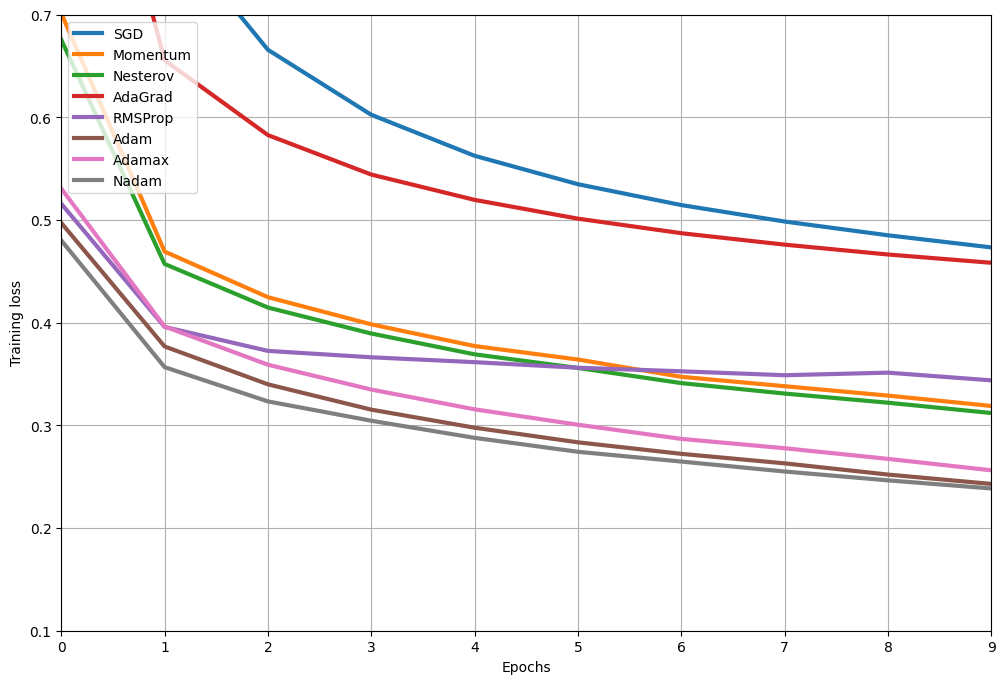

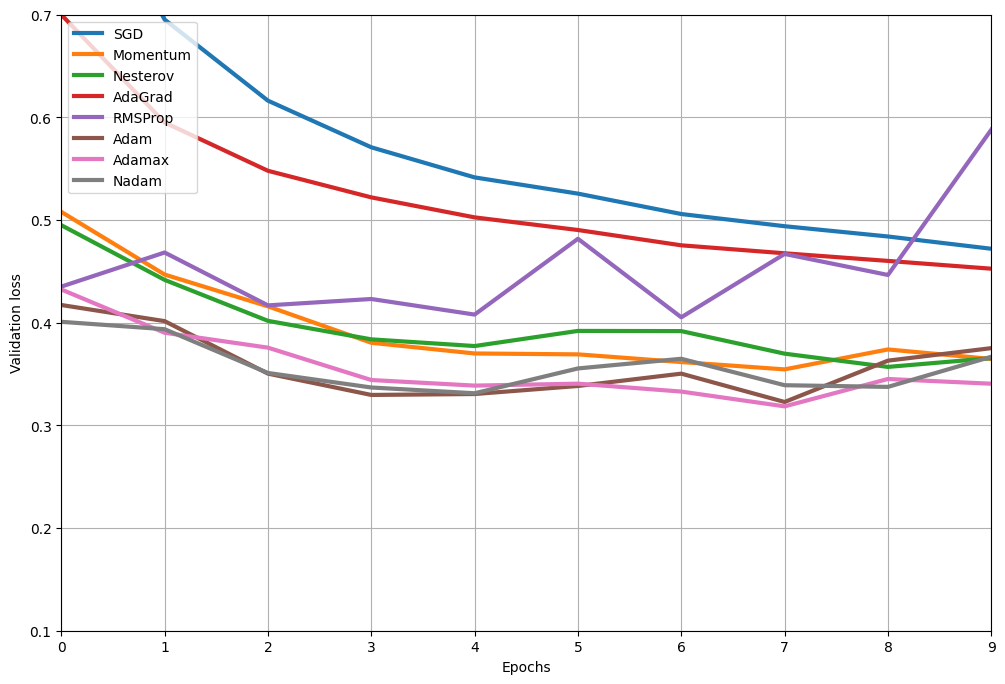

In [54]:
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

## Learning Rate Scheduling


### Power Scheduling


learning_rate = initial_learning_rate / (1 + step / decay_steps)**power
Keras uses power = 1.

Note: The decay argument in optimizers is deprecated. The old optimizers which implement the decay argument are still available in `tf.keras.optimizers.legacy`, but you should use the schedulers in `tf.keras.optimizers.schedules` instead.

In [55]:
# DEPRECATED:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-4)

In [56]:
# RECOMMENDED:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [57]:
history_power_scheduling = build_and_train_model(optimizer)  # extra code


Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6734 - accuracy: 0.7701 - val_loss: 0.4938 - val_accuracy: 0.8226
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4697 - accuracy: 0.8347 - val_loss: 0.4528 - val_accuracy: 0.8314
Epoch 3/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4267 - accuracy: 0.8487 - val_loss: 0.4145 - val_accuracy: 0.8518
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4050 - accuracy: 0.8576 - val_loss: 0.3933 - val_accuracy: 0.8600
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3864 - accuracy: 0.8629 - val_loss: 0.3916 - val_accuracy: 0.8576
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3727 - accuracy: 0.8679 - val_loss: 0.3903 - val_accuracy: 0.8612
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3620 - accuracy: 0.8707 - val_loss: 0.3721 - val_accuracy:

In [60]:
history_power_scheduling.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

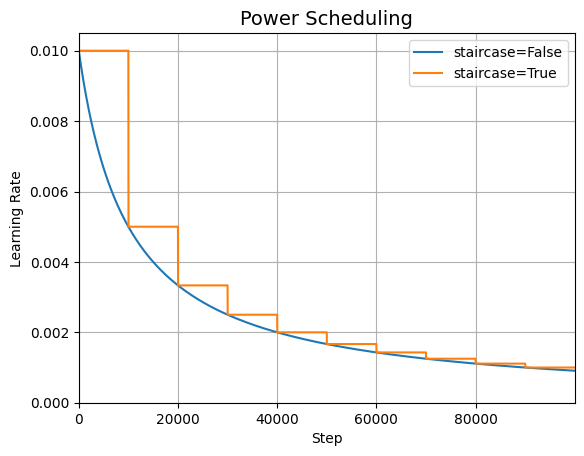

In [63]:
initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * steps / decay_steps)
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### Exponential Scheduling


learning_rate = initial_learning_rate * decay_rate ** (step / decay_steps)

In [61]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)


In [62]:
history_exponential_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7110 - accuracy: 0.7565 - val_loss: 0.5085 - val_accuracy: 0.8216
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4796 - accuracy: 0.8322 - val_loss: 0.4581 - val_accuracy: 0.8382
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4336 - accuracy: 0.8470 - val_loss: 0.4187 - val_accuracy: 0.8572
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4110 - accuracy: 0.8557 - val_loss: 0.4001 - val_accuracy: 0.8606
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3933 - accuracy: 0.8617 - val_loss: 0.3942 - val_accuracy: 0.8628
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3807 - accuracy: 0.8663 - val_loss: 0.3970 - val_accuracy: 0.8598
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3721 - accuracy: 0.8683 - val_loss: 0.3791 - val_accuracy:

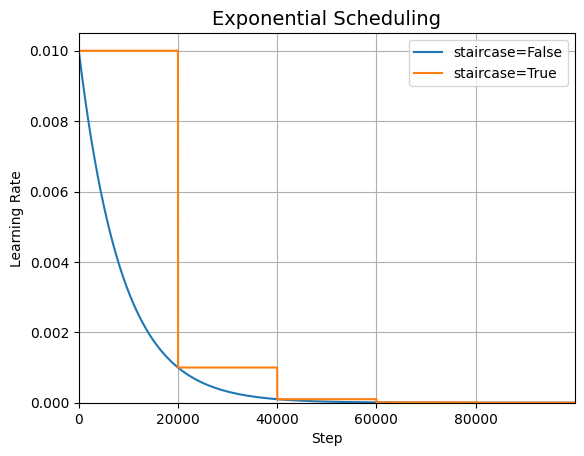

In [64]:
initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [65]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [66]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [67]:
tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
            metrics=["accuracy"])

In [68]:

n_epochs = 20

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6971 - accuracy: 0.7597 - val_loss: 0.4965 - val_accuracy: 0.8252 - lr: 0.0100
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4710 - accuracy: 0.8337 - val_loss: 0.4737 - val_accuracy: 0.8260 - lr: 0.0089
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4234 - accuracy: 0.8489 - val_loss: 0.4252 - val_accuracy: 0.8486 - lr: 0.0079
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3989 - accuracy: 0.8583 - val_loss: 0.3913 - val_accuracy: 0.8598 - lr: 0.0071
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3796 - accuracy: 0.8652 - val_loss: 0.3818 - val_accuracy: 0.8646 - lr: 0.0063
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3647 - accuracy: 0.8699 - val_loss: 0.3820 - val_accuracy: 0.8614 - lr: 0.0056
Epoch 7/20
1719/1719 [==============================] - 5s

Alternatively, the schedule function can take the current learning rate as a second argument:


In [69]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

to use a custom scheduling function that updates the learning rate at each iteration rather than at each epoch, you can write your own callback class like this:

In [70]:

K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [71]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [72]:
import math

batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6723 - accuracy: 0.7693 - val_loss: 0.4982 - val_accuracy: 0.8164 - lr: 0.0089
Epoch 2/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4648 - accuracy: 0.8358 - val_loss: 0.4493 - val_accuracy: 0.8390 - lr: 0.0079
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4199 - accuracy: 0.8510 - val_loss: 0.4094 - val_accuracy: 0.8560 - lr: 0.0071
Epoch 4/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3963 - accuracy: 0.8598 - val_loss: 0.3866 - val_accuracy: 0.8640 - lr: 0.0063
Epoch 5/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3780 - accuracy: 0.8665 - val_loss: 0.3773 - val_accuracy: 0.8652 - lr: 0.0056
Epoch 6/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3636 - accuracy: 0.8709 - val_loss: 0.3841 - val_accuracy: 0.8660 - lr: 0.0050
Epoch 7/20
1719/1719 [==============================] - 6s

### Piecewise Constant Scheduling


In [73]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000],
    values=[0.01, 0.005, 0.001]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [74]:
history_piecewise_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6804 - accuracy: 0.7689 - val_loss: 0.4841 - val_accuracy: 0.8260
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4678 - accuracy: 0.8357 - val_loss: 0.4424 - val_accuracy: 0.8406
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4188 - accuracy: 0.8509 - val_loss: 0.4179 - val_accuracy: 0.8526
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3937 - accuracy: 0.8597 - val_loss: 0.3835 - val_accuracy: 0.8654
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3723 - accuracy: 0.8671 - val_loss: 0.3729 - val_accuracy: 0.8664
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3569 - accuracy: 0.8713 - val_loss: 0.3810 - val_accuracy: 0.8686
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3454 - accuracy: 0.8752 - val_loss: 0.3686 - val_accuracy:

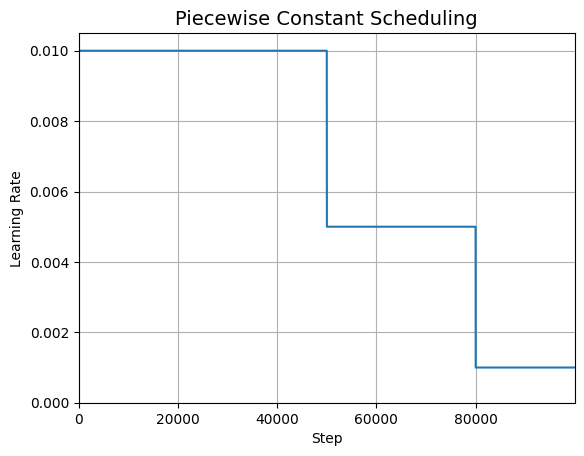

In [75]:
# extra code – this cell plots piecewise constant scheduling

boundaries = [50_000, 80_000]
values = [0.01, 0.005, 0.001]

steps = np.arange(100_000)

lrs = np.full(len(steps), values[0])
for boundary, value in zip(boundaries, values[1:]):
    lrs[boundary:] = value

plt.plot(steps, lrs, "-")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

Just like we did with exponential scheduling, we could also implement piecewise constant scheduling manually:

In [76]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [77]:
# extra code – this cell demonstrates a more general way to define
#              piecewise constant scheduling.

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [79]:
# extra code – use a tf.keras.callbacks.LearningRateScheduler like earlier

n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler],
                    # initial_epoch=19
                    )

Epoch 20/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4881 - accuracy: 0.8233 - val_loss: 0.4323 - val_accuracy: 0.8360 - lr: 0.0010
Epoch 21/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3610 - accuracy: 0.8680 - val_loss: 0.3702 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 22/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3275 - accuracy: 0.8784 - val_loss: 0.3458 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 23/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3065 - accuracy: 0.8876 - val_loss: 0.3292 - val_accuracy: 0.8786 - lr: 0.0010
Epoch 24/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2877 - accuracy: 0.8928 - val_loss: 0.3203 - val_accuracy: 0.8830 - lr: 0.0010
Epoch 25/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2758 - accuracy: 0.8980 - val_loss: 0.3449 - val_accuracy: 0.8744 - lr: 0.0010


full list in `tf.keras.optimizers.schedules`

In [80]:
for name in sorted(dir(tf.keras.optimizers.schedules)):
    if name[0] == name[0].lower():  # must start with capital letter
        continue
    scheduler_class = getattr(tf.keras.optimizers.schedules, name)
    print(f"• {name} – {scheduler_class.__doc__.splitlines()[0]}")

• CosineDecay – A LearningRateSchedule that uses a cosine decay schedule.
• CosineDecayRestarts – A LearningRateSchedule that uses a cosine decay schedule with restarts.
• ExponentialDecay – A LearningRateSchedule that uses an exponential decay schedule.
• InverseTimeDecay – A LearningRateSchedule that uses an inverse time decay schedule.
• LearningRateSchedule – The learning rate schedule base class.
• PiecewiseConstantDecay – A LearningRateSchedule that uses a piecewise constant decay schedule.
• PolynomialDecay – A LearningRateSchedule that uses a polynomial decay schedule.


### Performance Scheduling


In [81]:
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [82]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7053 - accuracy: 0.7551 - val_loss: 0.4959 - val_accuracy: 0.8222 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4706 - accuracy: 0.8328 - val_loss: 0.4533 - val_accuracy: 0.8362 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4224 - accuracy: 0.8482 - val_loss: 0.4139 - val_accuracy: 0.8538 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3980 - accuracy: 0.8589 - val_loss: 0.3858 - val_accuracy: 0.8596 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3769 - accuracy: 0.8657 - val_loss: 0.3814 - val_accuracy: 0.8634 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3612 - accuracy: 0.8698 - val_loss: 0.3786 - val_accuracy: 0.8620 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] - 5s

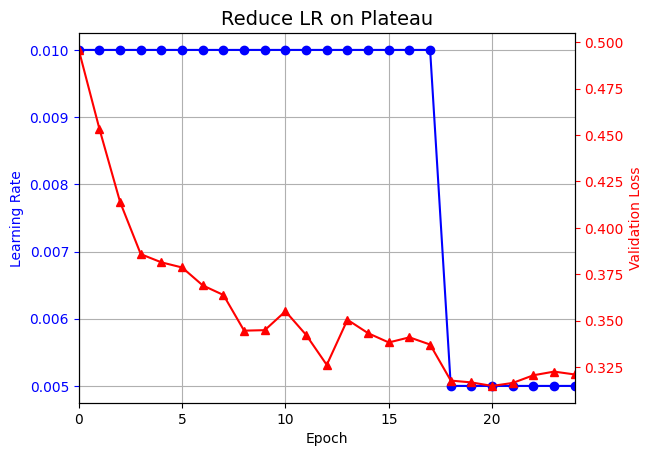

In [83]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### 1Cycle scheduling

The ExponentialLearningRate custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant factor. It also saves the learning rate and loss at each batch. Since logs["loss"] is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [84]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

The find_learning_rate() function trains the model using the ExponentialLearningRate callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [85]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The plot_lr_vs_loss() function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [86]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

In [87]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

430/430 [==============================] - 2s 4ms/step - loss: 1.8115 - accuracy: 0.3896


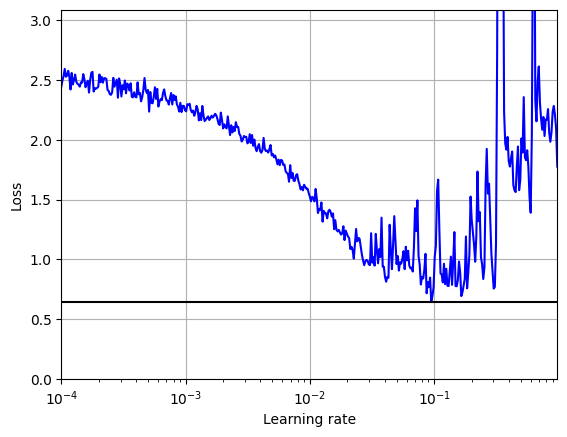

In [88]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

Looks like the max learning rate to use for 1cycle is around 10–1.



The `OneCycleScheduler` custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [89]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

In [90]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 2s 4ms/step - loss: 0.9555 - accuracy: 0.6864 - val_loss: 0.5830 - val_accuracy: 0.7990
Epoch 2/25
430/430 [==============================] - 1s 3ms/step - loss: 0.5680 - accuracy: 0.8018 - val_loss: 0.5039 - val_accuracy: 0.8202
Epoch 3/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4936 - accuracy: 0.8250 - val_loss: 0.4604 - val_accuracy: 0.8324
Epoch 4/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4477 - accuracy: 0.8408 - val_loss: 0.4195 - val_accuracy: 0.8458
Epoch 5/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4194 - accuracy: 0.8487 - val_loss: 0.4047 - val_accuracy: 0.8520
Epoch 6/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3945 - accuracy: 0.8572 - val_loss: 0.5446 - val_accuracy: 0.7988
Epoch 7/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3796 - accuracy: 0.8628 - val_loss: 0.4066 - val_accuracy: 0.8470
Epoch 

## Avoiding Overfitting Through Regularization

### $l1$ and $l2$ regularization

In [91]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

In [92]:
tf.random.set_seed(42)  # extra code – for reproducibility


In [93]:

from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

In [94]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 3.1251 - accuracy: 0.7692 - val_loss: 1.8564 - val_accuracy: 0.8220
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 1.4240 - accuracy: 0.8125 - val_loss: 1.1273 - val_accuracy: 0.8154


### Dropout


In [95]:
tf.random.set_seed(42)  # extra code – for reproducibility


model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [96]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6845 - accuracy: 0.7494 - val_loss: 0.4591 - val_accuracy: 0.8256
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5110 - accuracy: 0.8146 - val_loss: 0.4159 - val_accuracy: 0.8438
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4755 - accuracy: 0.8263 - val_loss: 0.4038 - val_accuracy: 0.8476
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4488 - accuracy: 0.8343 - val_loss: 0.3771 - val_accuracy: 0.8628
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4351 - accuracy: 0.8401 - val_loss: 0.3673 - val_accuracy: 0.8604
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4260 - accuracy: 0.8432 - val_loss: 0.3635 - val_accuracy: 0.8632
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4155 - accuracy: 0.8480 - val_loss: 0.3699 - val_accuracy:


The training accuracy looks like it's lower than the validation accuracy, but that's just because dropout is only active during training. If we evaluate the model on the training set after training (i.e., with dropout turned off), we get the "real" training accuracy, which is very slightly higher than the validation accuracy and the test accuracy:

In [97]:
model.evaluate(X_train, y_train)


1719/1719 [==============================] - 3s 2ms/step - loss: 0.3161 - accuracy: 0.8817


[0.3160823583602905, 0.881745457649231]

In [98]:
model.evaluate(X_test, y_test)


313/313 [==============================] - 1s 2ms/step - loss: 0.3698 - accuracy: 0.8659


[0.36976373195648193, 0.8658999800682068]

### MC Dropout

In [99]:
y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [100]:
model.predict(X_test[:1]).round(3)


1/1 [==============================] - 0s 83ms/step


array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.011, 0.   , 0.049, 0.   ,
        0.94 ]], dtype=float32)

In [103]:
y_proba[0].round(3)


array([0.   , 0.   , 0.   , 0.   , 0.   , 0.068, 0.   , 0.153, 0.   ,
       0.778], dtype=float32)

In [104]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.127, 0.   , 0.181, 0.   ,
       0.221], dtype=float32)

In [105]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.8676

In [106]:

class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)
    

# extra code – shows how to convert Dropout to MCDropout in a Sequential model
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])
mc_model.set_weights(model.get_weights())

In [107]:
mc_model.summary()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 784)               0         
                                                                 
 mc_dropout (MCDropout)      (None, 784)               0         
                                                                 
 dense_93 (Dense)            (None, 100)               78500     
                                                                 
 mc_dropout_1 (MCDropout)    (None, 100)               0         
                                                                 
 dense_94 (Dense)            (None, 100)               10100     
                                                                 
 mc_dropout_2 (MCDropout)    (None, 100)               0         
                                                                 
 dense_95 (Dense)            (None, 10)              

In [108]:
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1])
         for sample in range(100)], axis=0).round(2)

1/1 [==============================] - 0s 13ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.13, 0.  , 0.78]],
      dtype=float32)

### Max norm


In [109]:
dense = tf.keras.layers.Dense(
    100, activation="relu", kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.))

In [110]:
MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5520 - accuracy: 0.8018 - val_loss: 0.4319 - val_accuracy: 0.8336
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4129 - accuracy: 0.8500 - val_loss: 0.4144 - val_accuracy: 0.8412
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3807 - accuracy: 0.8600 - val_loss: 0.3812 - val_accuracy: 0.8624
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3618 - accuracy: 0.8665 - val_loss: 0.3626 - val_accuracy: 0.8638
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3479 - accuracy: 0.8710 - val_loss: 0.3413 - val_accuracy: 0.8700
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3426 - accuracy: 0.8737 - val_loss: 0.3928 - val_accuracy: 0.8550
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3333 - accuracy: 0.8751 - val_loss: 0.4011 - val_accuracy:

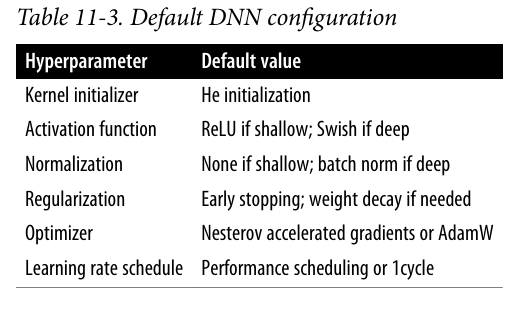

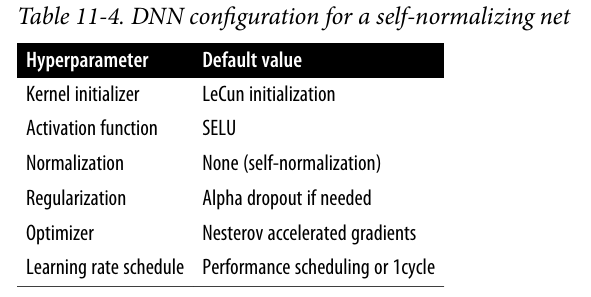